## Análise de Resultados

In [1]:
import sys, os
import plotly.graph_objects as go
import numpy as np

sys.path.insert(0, "/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz")
import pandas as pd
import argparse
import copy
import numpy as np
import os
import random
import json
from pandas.io.json import json_normalize
from app import fetch_iteraction_results_path, load_all_iteraction_metrics
from app import load_iteractions_params as load_iteractions_params2, PATH_EVAL_REINFORCEMENT
from plot import plot_line_iteraction, plot_exploration_arm, get_colors, confidence
import pandas as pd
import argparse
import copy
import numpy as np
import streamlit as st
import seaborn as sns
sns.set(style="darkgrid")
#sys.path.insert(0, os.path.dirname(__file__))
import matplotlib.pyplot as plt
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path


In [2]:
# models_and_legend = {
#   "____random_":           ["bandit_policy", "observation"],
#   "____fixed_":            ["bandit_policy", "observation"],
#   "____lin_ucb_":          ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
#   "____model_":            ["bandit_policy","full_refit", "val_split_type"],
#   "____custom_lin_ucb_":   ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
#   "____epsilon_greedy_":   ["bandit_policy","bandit_policy_params.epsilon", "full_refit", "val_split_type"],
#   "____softmax_":          ["bandit_policy","bandit_policy_params.logit_multiplier", "full_refit", "val_split_type"],
#   "____lin_ts_":           ["bandit_policy","bandit_policy_params.v_sq", "full_refit", "val_split_type"],
#   "____percentile_adapt_":       ["bandit_policy","bandit_policy_params.exploration_threshold", "full_refit", "val_split_type"],
#   "____adaptive_":         ["bandit_policy","bandit_policy_params.exploration_threshold", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],  
#   "____explore_then_exp_": ["bandit_policy","bandit_policy_params.explore_rounds", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],    
# }

models_and_legend = {
  "____remote_":           ["bandit_policy", "obs"],
}
path = PATH_EVAL_REINFORCEMENT

In [3]:
models_and_legend

{'____remote_': ['bandit_policy', 'obs']}

In [4]:
def list_paths_per_model(input_path):
    models = []
    
    for model, legend in models_and_legend.items():
    #print(model)
    #print(legend)
        for root, dirs, files in os.walk(input_path):
            if '/results' in root and 'Interaction' in root:
                for d in dirs:
                    #print(os.path.join(root, d))
                    if model in d:
                        models.append(os.path.join(root, d))
    return models

def load_iteractions_params(iteractions):
  if len(iteractions) == 0:
    return pd.DataFrame()

  dfs = []

  for model in iteractions:

    file_path = os.path.join(model, 'params.json')
    data      = []

    #try:
    with open(file_path) as json_file:
        d = json.load(json_file)
        data.append(d)

        df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')
      
    #except:
    #  df = pd.DataFrame()

    df['iteraction'] = model
    dfs.append(df)
  
  return pd.concat(dfs)


def load_data_iteractions_metrics(path, sample_size = 10000):
    random.seed(42)
    file      = os.path.join(path,'sim-datalog.csv')

    # Count the lines
    num_lines = sum(1 for l in open(file)) - 1

    # Sample size - in this case ~10%
    size = np.min([sample_size, num_lines])#int(num_lines / 10)

    # The row indices to skip - make sure 0 is not included to keep the header!
    skip_idx  = sorted(random.sample(range(1, num_lines), num_lines - size))
    idx       = list(set(list(range(num_lines))) - set(skip_idx))

    df        = pd.read_csv(file, skiprows=skip_idx)
    
    df        = pd.read_csv(file)#.reset_index()
    idx       = list(range(len(df)))

    df['idx'] = sorted(idx)
    df        = df.sort_values("idx")
    return df


def get_metrics_reward(bandits):
    data    = []
    for i, p in enumerate(bandits):
        df_metrics = load_data_iteractions_metrics(p)
        r_mean     = df_metrics.reward.mean()
        r_reward   = df_metrics.reward.sum()
        data.append((i, r_mean, r_reward))
    df_metrics = pd.DataFrame(data, columns=['idx', 'r_mean', 'r_reward']).set_index('idx')    
    return df_metrics

def group_metrics(df):
    df_g_metrics = df.groupby('bandit').agg({'r_mean': ['mean', 'std'], 'r_reward': ['mean', 'std', 'count'], 'model': 'first' })
    df_g_metrics.columns = df_g_metrics.columns.map(lambda x: '|'.join([str(i) for i in x]))
    return df_g_metrics    
    
result_paths = list_paths_per_model(path)
result_paths

['output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______ae87ca9ccb',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______d7ec2bac42',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______af7c690687',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a0eec06ce4',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______e681969ab3',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______3d7e28c225',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a76a90a61e',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43',
 'output/interaction/Ensambl

In [5]:
fetch_results_path()

{'TrivagoLogisticModelInteraction_selu____softmax_explorer_ecf6ca42ee_89372c6587_ps_per_logistic_regression_of_pos_item_idx_and_item_ps': 'output/evaluation/EvaluateTrivagoTestSetPredictions/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_ecf6ca42ee_89372c6587_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'}

## Filter Data

In [6]:
result_paths

['output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______ae87ca9ccb',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______d7ec2bac42',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______af7c690687',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a0eec06ce4',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______e681969ab3',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______3d7e28c225',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a76a90a61e',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43',
 'output/interaction/Ensambl

In [7]:
df_params = load_iteractions_params(result_paths)
df_params.head()

/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,balance_fields,bandit_policy,bandit_policy_params.endpoints,bandit_policy_params.epsilon,bandit_policy_params.logit_multiplier,bandit_policy_params.window_reward,batch_size,dataset_split_method,device,early_stopping_min_delta,...,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,user_column,user_idx_column,val_size,val_split_type
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,NaN,500,time,cuda,0.001,...,5,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,NaN,500,time,cuda,0.001,...,6,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_epsilon_greedy,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,500.0,500,time,cuda,0.001,...,2,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_softmax,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,NaN,500,time,cuda,0.001,...,6,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,NaN,500,time,cuda,0.001,...,2,0.1,0,0.0,time,False,account_id,account_idx,0.0,time


In [8]:
df_params.obs.unique()

array(['[MAB] UCB  5', '[MAB] UCB  6', '[MAB] e-greedy 2',
       '[Contextual] Softmax 6', '[MAB] UCB  2', '[MAB] e-greedy 5',
       '[Contextual]e-greedy(10) 1', 'MostPopularPerUser',
       '[Contextual]e-greedy(20) 1', '[Contextual] Softmax 3',
       '[Contextual] e-greedy 1', '[Contextual]Softmax(50) 1',
       '[MAB] e-greedy 10', '[Contextual]Softmax(10) 2',
       '[Contextual] e-greedy 8', 'CDAE', '[MAB] e-greedy 9',
       '[MAB] UCB  3', 'MostPopular', '[MAB] e-greedy 3',
       'MatrixFactorization', '[Contextual] e-greedy 4',
       '[MAB] e-greedy 1', '[Contextual]Softmax(100) 1',
       '[Contextual] Softmax 2', '[MAB] e-greedy 4',
       '[Contextual] Softmax 1', '[Contextual] e-greedy 9',
       '[Contextual]Softmax(500) 1', '[Contextual] e-greedy 7',
       '[MAB] UCB  7', '[Contextual]e-greedy(5) 1', '[MAB] UCB  4',
       '[Contextual] Softmax 9', '[Contextual] Softmax 8', '[MAB] UCB  9',
       '[MAB] UCB  1', '[Contextual] Softmax 10',
       '[Contextual] e-gre

In [9]:
df_params['obs'].apply(lambda x: " ".join(x.split(" ")[:-1]).strip()).unique()

array(['[MAB] UCB', '[MAB] e-greedy', '[Contextual] Softmax',
       '[Contextual]e-greedy(10)', '', '[Contextual]e-greedy(20)',
       '[Contextual] e-greedy', '[Contextual]Softmax(50)',
       '[Contextual]Softmax(10)', '[Contextual]Softmax(100)',
       '[Contextual]Softmax(500)', '[Contextual]e-greedy(5)'],
      dtype=object)

In [10]:
df_params
#df_params['observation'] = df_params['obs'].apply(lambda x: " ".join(x.split(" ")[:-2]))
df_params['observation'] = df_params['obs'].apply(lambda x: " ".join(x.split(" ")[:-1]) if len(x.split(" ")) > 1 else x)
#df_params['observation'] = df_params['observation']+df_params['logit_multiplier']

df_params['observation'].unique()

array(['[MAB] UCB ', '[MAB] e-greedy', '[Contextual] Softmax',
       '[Contextual]e-greedy(10)', 'MostPopularPerUser',
       '[Contextual]e-greedy(20)', '[Contextual] e-greedy',
       '[Contextual]Softmax(50)', '[Contextual]Softmax(10)', 'CDAE',
       'MostPopular', 'MatrixFactorization', '[Contextual]Softmax(100)',
       '[Contextual]Softmax(500)', '[Contextual]e-greedy(5)', 'CVAE',
       'Random'], dtype=object)

In [11]:
list_bandits          = df_params.groupby(["bandit_policy", "observation"])['iteraction'].apply(list).reset_index()
list_bandits['name']  = list_bandits.bandit_policy.map(str) + ' ' + list_bandits.observation.map(str)
list_bandits['name']  = list_bandits['name'].apply(lambda x: x.replace("fixed ", "").replace(" ", ""))
list_bandits['model'] = list_bandits.iteraction.apply(lambda l: l[np.random.randint(0, len(l))])
list_bandits['model_list'] = list_bandits.iteraction
list_bandits

,bandit_policy,observation,iteraction,name,model,model_list
0,remote,CDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6],remoteCDAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
1,remote,CVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920],remoteCVAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]
2,remote,MatrixFactorization,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b],remoteMatrixFactorization,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b]
3,remote,MostPopular,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a],remoteMostPopular,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a]
4,remote,MostPopularPerUser,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43],remoteMostPopularPerUser,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43]
5,remote,Random,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7],remoteRandom,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7]
6,remote_contextual_epsilon_greedy,[Contextual] e-greedy,"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c87eb8d2e4, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c8e04246ca, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4e6c98d63b, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______fcb92f2a09, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______08b565350d, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______28dd73806b, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______659dab8004, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______e7f48c2e17, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______7d9bc9b8c0, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______09a2bee226]",remote_contextual_epsilon_greedy[Contextual]e-greedy,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______e7f48c2e17,"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c87eb8d2e4, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c8e0

In [12]:
df_params

,balance_fields,bandit_policy,bandit_policy_params.endpoints,bandit_policy_params.epsilon,bandit_policy_params.logit_multiplier,bandit_policy_params.window_reward,batch_size,dataset_split_method,device,early_stopping_min_delta,...,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,user_column,user_idx_column,val_size,val_split_type
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,NaN,500,time,cuda,0.001,...,5,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,NaN,500,time,cuda,0.001,...,6,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_epsilon_greedy,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,500.0,500,time,cuda,0.001,...,2,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_softmax,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,NaN,500,time,cuda,0.001,...,6,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,NaN,500,time,cuda,0.001,...,2,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_epsilon_greedy,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,500.0,500,time,cuda,0.001,...,5,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.10,NaN,NaN,500,time,cuda,0.001,...,1,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote,[http://localhost:5002/rank],NaN,NaN,NaN,500,time,cuda,0.001,...,42,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.20,NaN,NaN,500,time,cuda,0.001,...,1,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_softmax,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,NaN,500,time,cuda,0.001,...,3,0.1,0,0.0,time,False,account_id,account_idx,0.0,time


## Geral

In [13]:
reward_metrics = []
list_bandits.head(2)

,bandit_policy,observation,iteraction,name,model,model_list
0,remote,CDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6],remoteCDAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
1,remote,CVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920],remoteCVAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]


In [14]:
for i, row in list_bandits.iterrows():
    try:
        df_metrics = get_metrics_reward(row['iteraction'])
        
        df_metrics['bandit'] = str(row['bandit_policy']) + " " + str(row['observation'])
        df_metrics['model']  = row['model']

        df_g_metrics = group_metrics(df_metrics)
        reward_metrics.append(df_g_metrics)
    except FileNotFoundError:
        pass

In [15]:
df_all = pd.concat(reward_metrics)
df_all = df_all.reset_index().sort_values('bandit', ascending=False).set_index('bandit')
df_all

,r_mean|mean,r_mean|std,r_reward|mean,r_reward|std,r_reward|count,model|first
bandit,,,,,,
remote_ucb [MAB] UCB,0.107383,0.000000,1232.0,0.000000,10,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______e681969ab3
remote_epsilon_greedy [MAB] e-greedy,0.109474,0.000000,1256.0,0.000000,10,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______f28b59cf0c
remote_contextual_softmax [Contextual]Softmax(500),0.163950,NaN,1881.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______55794896b4
remote_contextual_softmax [Contextual]Softmax(50),0.144077,NaN,1653.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______f084716da3
remote_contextual_softmax [Contextual]Softmax(100),0.160028,NaN,1836.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______6671e873d0
remote_contextual_softmax [Contextual] Softmax,0.111836,0.000251,1283.1,2.884826,10,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a0eec06ce4
remote_contextual_epsilon_greedy [Contextual]e-greedy(5),0.164560,NaN,1888.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______80ea313ae2
remote_contextual_epsilon_greedy [Contextual]e-greedy(20),0.150527,NaN,1727.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______bfe9016dc1
remote_contextual_epsilon_greedy [Contextual]e-greedy(10),0.161074,NaN,1848.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a76a90a61e


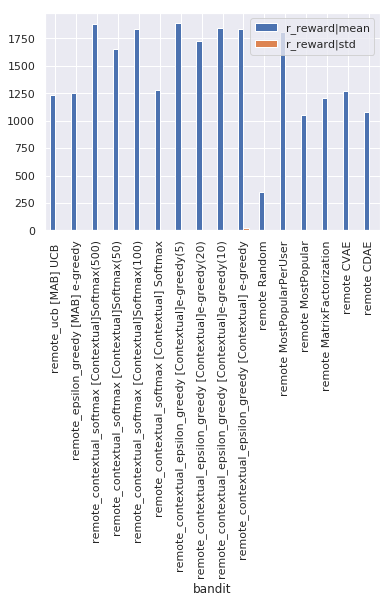

In [16]:
df_all[['r_reward|mean', 'r_reward|std']].plot(kind='bar')

In [17]:
df_all.to_csv("output/tmp/stats.csv")

## Plot Test

In [21]:
df_all.index.unique()

Index(['remote_ucb [MAB] UCB ', 'remote_epsilon_greedy [MAB] e-greedy',
       'remote_contextual_softmax [Contextual]Softmax(500)',
       'remote_contextual_softmax [Contextual]Softmax(50)',
       'remote_contextual_softmax [Contextual]Softmax(100)',
       'remote_contextual_softmax [Contextual] Softmax',
       'remote_contextual_epsilon_greedy [Contextual]e-greedy(5)',
       'remote_contextual_epsilon_greedy [Contextual]e-greedy(20)',
       'remote_contextual_epsilon_greedy [Contextual]e-greedy(10)',
       'remote_contextual_epsilon_greedy [Contextual] e-greedy',
       'remote Random', 'remote MostPopularPerUser', 'remote MostPopular',
       'remote MatrixFactorization', 'remote CVAE', 'remote CDAE'],
      dtype='object', name='bandit')

In [23]:
list_bandits.name

0     remoteCDAE                                              
1     remoteCVAE                                              
2     remoteMatrixFactorization                               
3     remoteMostPopular                                       
4     remoteMostPopularPerUser                                
5     remoteRandom                                            
6     remote_contextual_epsilon_greedy[Contextual]e-greedy    
7     remote_contextual_epsilon_greedy[Contextual]e-greedy(10)
8     remote_contextual_epsilon_greedy[Contextual]e-greedy(20)
9     remote_contextual_epsilon_greedy[Contextual]e-greedy(5) 
10    remote_contextual_softmax[Contextual]Softmax            
11    remote_contextual_softmax[Contextual]Softmax(10)        
12    remote_contextual_softmax[Contextual]Softmax(100)       
13    remote_contextual_softmax[Contextual]Softmax(50)        
14    remote_contextual_softmax[Contextual]Softmax(500)       
15    remote_epsilon_greedy[MAB]e-greedy               

In [35]:
list_bandits['name'] = list_bandits['name'].apply(lambda x: "popular_item" if x == "PopularItem" else x)
df_models = list_bandits.set_index('name')[['model_list']]


legend = {'remoteCDAE': "CDAE", 
         'remoteCVAE': "CVAE",  
         'remoteMatrixFactorization': 'Matrix Factorization',
         'remoteMostPopular': 'Most Popular',
         'remoteMostPopularPerUser': 'Most Popular per User',
         'remoteRandom': 'Random',
         'remote_contextual_epsilon_greedy[Contextual]e-greedy': 'Contextual e-greedy',
         'remote_contextual_softmax[Contextual]Softmax': 'Contextual Softmax',
         'remote_epsilon_greedy[MAB]e-greedy': 'e-greedy', 
         'remote_ucb[MAB]UCB': 'UCB',
         'remote_contextual_softmax[Contextual]Softmax(10)':'Contextual Softmax (c=10)', 
         'remote_contextual_softmax[Contextual]Softmax(50)':'Contextual Softmax (c=50)',
         'remote_contextual_softmax[Contextual]Softmax(100)':'Contextual Softmax (c=100)',
         'remote_contextual_softmax[Contextual]Softmax(500)':'Contextual Softmax (c=500)',
         'remote_contextual_epsilon_greedy[Contextual]e-greedy(5)': 'Contextual e-greedy (e=0.05)',
         'remote_contextual_epsilon_greedy[Contextual]e-greedy(10)': 'Contextual e-greedy (e=0.1)',
         'remote_contextual_epsilon_greedy[Contextual]e-greedy(20)': 'Contextual e-greedy (e=0.2)',
        }

df_models.index = df_models.index.map(legend)
#df_models['model'] = df_models['bandit']
df_models.head(10)

,model_list
name,
CDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
CVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]
Matrix Factorization,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b]
Most Popular,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a]
Most Popular per User,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43]
Random,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7]
Contextual e-greedy,"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c87eb8d2e4, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c8e04246ca, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4e6c98d63b, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______fcb92f2a09, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______08b565350d, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______28dd73806b, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______659dab8004, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______e7f48c2e17, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______7d9bc9b8c0, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______09a2bee226]"
Contextual e-greedy (e=0.1),[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a76a90a61e]
Contextual e-greedy (e=0.2),[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______bfe9016dc1]


In [36]:
bandits           = legend.values()

sample_size       = 15000
window_size       = 1000 

In [37]:
# df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)

# df_metrics.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).rolling(window = window_size, min_periods=1).mean().reset_index(drop=True)

In [38]:
def load_dataset(df_models, bandits, sample_size):
    data = []
    for bandit in bandits:
        input_iteraction  = [p.split("/")[-1] for p in df_models.loc[bandit].model_list]
        df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)
        #params            = load_iteractions_params2(input_iteraction)
        
        
        df        = load_all_iteraction_metrics(input_iteraction, sample_size)
        df['_idx'] = 1
        df_metrics                    = df.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).cumsum().reset_index()
        df_metrics['mean_reward']     = (df_metrics.reward/df_metrics._idx).fillna(0)
        df_metrics['mean_reward_win'] = df.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).rolling(window = window_size, min_periods=1).mean().reset_index(drop=True).reward

        df_metrics['bandit']      = bandit
        df_metrics['Model']       = bandit

        data.append(df_metrics)
    return pd.concat(data, ignore_index=True)

    
df_group = load_dataset(df_models, bandits, sample_size)
df_group.tail()

,iteraction,idx,user,item,reward,index_env,_idx,mean_reward,mean_reward_win,bandit,Model
619537,EnsambleMABInteraction____remote_contextua___endpoints______bfe9016dc1,11468,2730766679,43063375,1725.0,65763246,11469,0.150405,0.123,Contextual e-greedy (e=0.2),Contextual e-greedy (e=0.2)
619538,EnsambleMABInteraction____remote_contextua___endpoints______bfe9016dc1,11469,2731015101,43068302,1725.0,65774715,11470,0.150392,0.122,Contextual e-greedy (e=0.2),Contextual e-greedy (e=0.2)
619539,EnsambleMABInteraction____remote_contextua___endpoints______bfe9016dc1,11470,2731278512,43076537,1725.0,65786185,11471,0.150379,0.121,Contextual e-greedy (e=0.2),Contextual e-greedy (e=0.2)
619540,EnsambleMABInteraction____remote_contextua___endpoints______bfe9016dc1,11471,2731406796,43079561,1726.0,65797656,11472,0.150453,0.121,Contextual e-greedy (e=0.2),Contextual e-greedy (e=0.2)
619541,EnsambleMABInteraction____remote_contextua___endpoints______bfe9016dc1,11472,2731788585,43084043,1727.0,65809128,11473,0.150527,0.121,Contextual e-greedy (e=0.2),Contextual e-greedy (e=0.2)


In [39]:
#df_group['idx'].isin(df_group.idx.sample(200, random_state=41))

### Cumulative Reward

In [40]:
def plot_cum_reward(df, column='mean_reward', hue='bandit', legend=False, ylim=1, hue_order=None):
    #df = df[df.idx > 10]
    steps = int(df_group.idx.max()/25)
    idx   = [steps*i for i in range(steps)]    
    df = df[df.idx.isin(idx)]
    #df = df.sample(200, random_state=41)
    
    plt.figure()
    sns.set(style="darkgrid")

    # Plot the responses for different events and regions
    ax =  sns.lineplot(x="idx", y=column, markers=markers, dashes=False, palette=palette,
                       style=hue, hue=hue, hue_order=hue_order, legend=legend,  data=df)
    ax.set_ylim(0,ylim)
    #ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward',fontsize=20)
    ax.tick_params(labelsize=11)
    ax.set_xlabel('Interactions',fontsize=15);
    ax.set_ylabel('Cumulative Reward',fontsize=15);
    # Put the legend out of the figure
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
    plt.savefig("output/tmp/plot_cum_reward.pdf",dpi=300, bbox_inches="tight")
    plt.show()

#### Cumulate Reward hyperparams

In [41]:
legend.values()

dict_values(['CDAE', 'CVAE', 'Matrix Factorization', 'Most Popular', 'Most Popular per User', 'Random', 'Contextual e-greedy', 'Contextual Softmax', 'e-greedy', 'UCB', 'Contextual Softmax (c=10)', 'Contextual Softmax (c=50)', 'Contextual Softmax (c=100)', 'Contextual Softmax (c=500)', 'Contextual e-greedy (e=0.05)', 'Contextual e-greedy (e=0.1)', 'Contextual e-greedy (e=0.2)'])

In [42]:
models  = ['Contextual Softmax (c=10)', 'Contextual Softmax (c=50)', 'Contextual Softmax (c=100)', 'Contextual Softmax (c=500)']
palette = dict(zip(models, sns.color_palette("deep", 7)))
markers = dict(zip(models, ["o","s", "P", "X", "d", "^", "v"]))

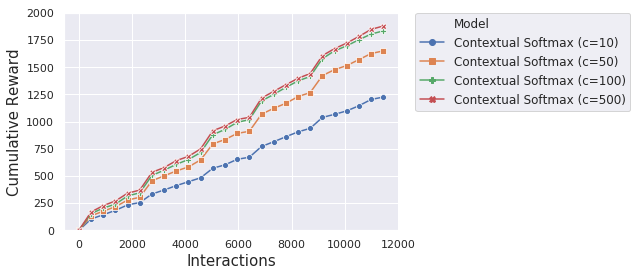

In [43]:
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).median().reset_index()

plot_cum_reward(df_group, column='reward', legend='full', hue='Model', hue_order=models, ylim=2000)

In [44]:
models  = ['Contextual e-greedy (e=0.05)', 'Contextual e-greedy (e=0.1)', 'Contextual e-greedy (e=0.2)']
palette = dict(zip(models, sns.color_palette("deep", 7)))
markers = dict(zip(models, ["o","s", "P", "X", "d", "^", "v"]))

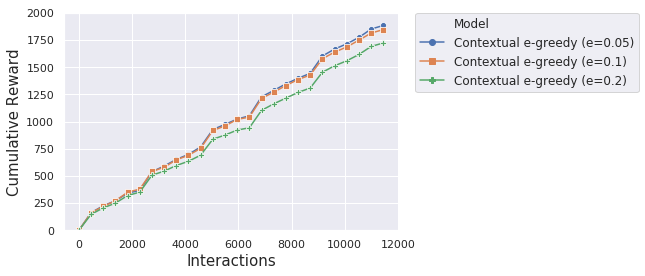

In [45]:
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).median().reset_index()

plot_cum_reward(df_group, column='reward', legend='full', hue='Model', hue_order=models, ylim=2000)

#### Cumulate Reward Best Models

In [46]:
legend.values()

dict_values(['CDAE', 'CVAE', 'Matrix Factorization', 'Most Popular', 'Most Popular per User', 'Random', 'Contextual e-greedy', 'Contextual Softmax', 'e-greedy', 'UCB', 'Contextual Softmax (c=10)', 'Contextual Softmax (c=50)', 'Contextual Softmax (c=100)', 'Contextual Softmax (c=500)', 'Contextual e-greedy (e=0.05)', 'Contextual e-greedy (e=0.1)', 'Contextual e-greedy (e=0.2)'])

In [55]:
models  = ['Contextual e-greedy (e=0.05)', 'Contextual Softmax (c=500)', 'CVAE', 'CDAE', 
          'Matrix Factorization', 'Most Popular', 'Random']
palette = dict(zip(models, sns.color_palette("deep", 7)))

markers = dict(zip(models, ["o","s", "P", "X", "d", "^", "v"]))

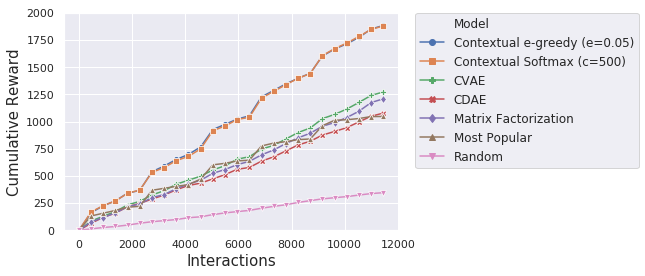

In [56]:

df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).median().reset_index()

plot_cum_reward(df_group, column='reward', legend='full', hue='Model', hue_order=models, ylim=2000)

### Cumulative Mean Reward

In [58]:
from matplotlib.colors import LogNorm
def plot_cum_mean_reward(df, column='mean_reward', hue='bandit', hue_order=None, 
                         legend=False, ylim=1, title="plot_cum_mean_reward", palette=palette):
    #df = df.sample(200, random_state=41)
    
    steps = int(df_group.idx.max()/25)
    idx   = [steps*i for i in range(steps)]    
    df = df[df.idx.isin(idx)]
    
    plt.figure()
    sns.set(style="darkgrid")

    # Plot the responses for different events and regions
    ax =  sns.lineplot(x="idx", y=column, markers=markers, dashes=False, palette=palette,
                       style=hue, hue=hue, hue_order=hue_order, legend=legend, data=df)
    ax.set_ylim(0,ylim)
    #ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward',fontsize=20)
    ax.tick_params(labelsize=11)
    ax.set_xlabel('Interactions',fontsize=15);
    ax.set_ylabel('Cumulative Mean Reward',fontsize=15);
    # Put the legend out of the figure
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
    plt.savefig("output/tmp/{}.pdf".format(title),dpi=300, bbox_inches="tight")
    plt.show()


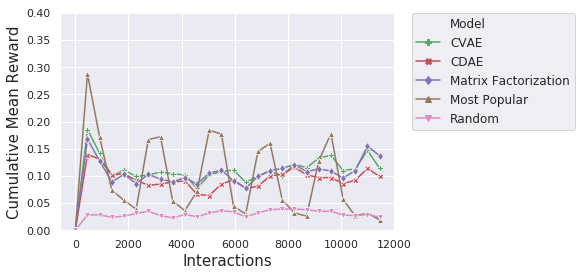

In [59]:
models  = ['CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_models",
                     legend='full',hue_order=models, hue='Model', ylim=0.4)

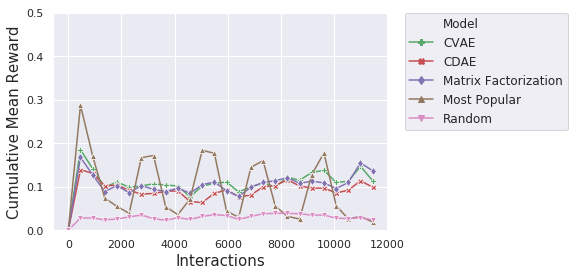

In [61]:
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', legend='full',hue_order=models, hue='Model', ylim=0.5)

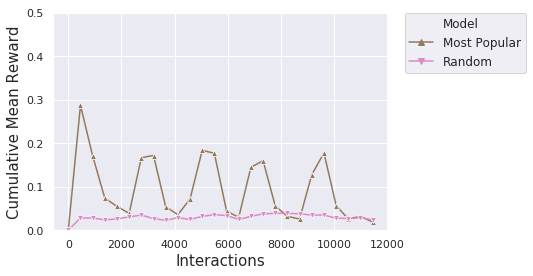

In [63]:
df_group = load_dataset(df_models, ['Random', 'Most Popular'], sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', legend='full', hue='Model', ylim=0.5)

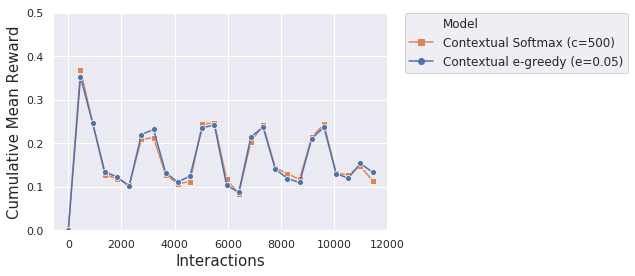

In [64]:

df_group = load_dataset(df_models, ['Contextual e-greedy (e=0.05)', 'Contextual Softmax (c=500)'], sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', legend='full', hue='Model', ylim=0.5)

## Explorer Bandit 

In [65]:
import pandas as pd
import pickle
import re
import sys
import numpy as np
import streamlit as st
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import os
import seaborn as sns
import plotly.express as px

In [99]:
bandits  = ['Contextual e-greedy (e=0.05)', 'Contextual Softmax (c=500)']
df_group = load_dataset(df_models, bandits, sample_size)
df_group.tail()

df_plot = df_group.sort_values('reward').groupby('iteraction').last().reset_index()
df_plot

,iteraction,idx,user,item,reward,index_env,_idx,mean_reward,mean_reward_win,bandit,Model
0,EnsambleMABInteraction____remote_contextua___endpoints______55794896b4,11472,2731788585,41106772,1881.0,65809128,11473,0.16395,0.105,Contextual Softmax (c=500),Contextual Softmax (c=500)
1,EnsambleMABInteraction____remote_contextua___endpoints______80ea313ae2,11472,2731788585,42125716,1888.0,65809128,11473,0.16456,0.125,Contextual e-greedy (e=0.05),Contextual e-greedy (e=0.05)


In [100]:
import gc
gc.collect()

0

In [101]:
def load_bandit(iteraction):
    path = '/media/workspace/DeepFood/deep-reco-gym/output/interaction/EnsambleMABInteraction/results/{}/'.format(iteraction)
    bandit = pickle.load(open(path+"/"+"bandit.pkl", "rb"))
    return bandit
bandit = load_bandit(df_plot.iloc[0].iteraction)

In [102]:
def get_arms(bandit):
    arms    = np.unique(bandit._arms_selected)
    arms_rewards = bandit._arms_selected
    rounds  = len(bandit._arms_selected)
    count_per_arms = {}

    for a in arms:
        count_per_arms[a] = np.zeros(rounds)


    for r in range(rounds):
        count_per_arms[arms_rewards[r]][r] = 1

    return count_per_arms

In [103]:
count_per_arms = get_arms(bandit)
count_per_arms

{0: array([1., 0., 0., ..., 1., 0., 1.]),
 1: array([0., 0., 0., ..., 0., 0., 0.]),
 2: array([0., 1., 0., ..., 0., 1., 0.]),
 3: array([0., 0., 1., ..., 0., 0., 0.])}

In [104]:
def stack_values(count_per_arms, window = 1000):

    values = count_per_arms[0]

    arm1 = pd.Series(count_per_arms[0]).rolling(window = window, min_periods=1).mean()
    arm2 = pd.Series(count_per_arms[1]).rolling(window = window, min_periods=1).mean()
    arm3 = pd.Series(count_per_arms[2]).rolling(window = window, min_periods=1).mean()
    arm4 = pd.Series(count_per_arms[3]).rolling(window = window, min_periods=1).mean()

    data = pd.DataFrame({'arm1': arm1, 'arm2': arm2, 'arm3': arm3, 'arm4': arm4})
    return data

data = stack_values(count_per_arms, window = 1000)

In [105]:
bandit._endpoints

('http://localhost:5001/rank',
 'http://localhost:5003/rank',
 'http://localhost:5004/rank',
 'http://localhost:5005/rank')

In [106]:
palette

{'Contextual e-greedy (e=0.05)': (0.2980392156862745,
  0.4470588235294118,
  0.6901960784313725),
 'Contextual Softmax (c=500)': (0.8666666666666667,
  0.5176470588235295,
  0.3215686274509804),
 'CVAE': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 'CDAE': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 'Matrix Factorization': (0.5058823529411764,
  0.4470588235294118,
  0.7019607843137254),
 'Most Popular': (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 'Random': (0.8549019607843137, 0.5450980392156862, 0.7647058823529411)}

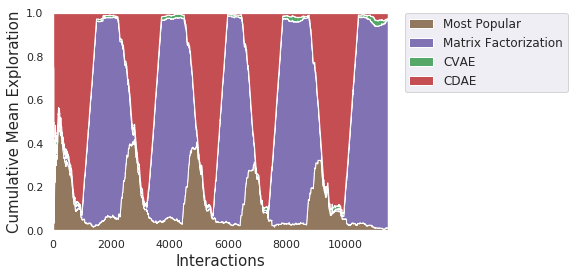

In [111]:
def plot_exploration(data, title = "exploration_fig.pdf", 
                     labels=['Most Popular', 'Matrix Factorization','CVAE', 'CDAE']):

    colors=[palette[l] for l in labels]
    #models  = ['CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
    plt.figure()

    sns.set(style="darkgrid")
    plt.xlabel('Interactions', fontsize=15)
    plt.ylabel('Cumulative Mean Exploration', fontsize=15)


    # We need to transform the data from raw data to percentage (fraction)
    data_perc = data.divide(data.sum(axis=1), axis=0)

    # Make the plot
    plt.stackplot(range(len(data)),  data_perc["arm1"],  data_perc["arm2"],  
                  data_perc["arm3"],  data_perc["arm4"], labels=labels, colors=colors)
    plt.legend(loc='upper left')
    plt.margins(0,0)

    plt.tick_params(labelsize=11)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
    plt.savefig("output/tmp/{}.pdf".format(title),dpi=300, bbox_inches="tight")
    plt.show()
    
plot_exploration(data)

range(0, 11473)

### Plot

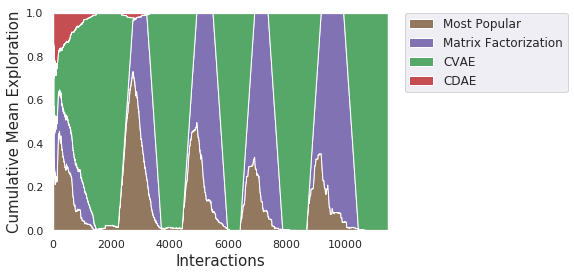

In [118]:
model  = df_plot.iloc[0]
bandit = load_bandit(model.iteraction)
count_per_arms = get_arms(bandit)
data = stack_values(count_per_arms, window = 500)
plot_exploration(data)

In [109]:
model

iteraction         EnsambleMABInteraction____remote_contextua___endpoints______55794896b4
idx                11472                                                                 
user               2731788585                                                            
item               41106772                                                              
reward             1881                                                                  
index_env          65809128                                                              
_idx               11473                                                                 
mean_reward        0.16395                                                               
mean_reward_win    0.105                                                                 
bandit             Contextual Softmax (c=500)                                            
Model              Contextual Softmax (c=500)                                            
Name: 0, d

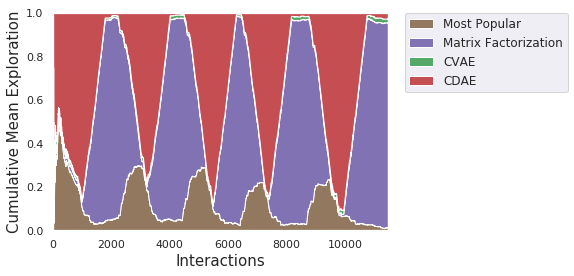

In [121]:
model  = df_plot.iloc[1]

bandit = load_bandit(model.iteraction)
count_per_arms = get_arms(bandit)
data = stack_values(count_per_arms, window = 800)
plot_exploration(data)

In [ ]:
# input_iteraction  = [p.split("/")[-1] for p in df_models.loc['remoteCDAE'].model_list]

# df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)
# df_metrics['_idx'] = 1
# df_metrics        = df_metrics.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).cumsum().reset_index()
# df_metrics['mean_reward'] = (df_metrics.reward/df_metrics.idx).fillna(0)
# df_metrics['cum_reward']  = df_metrics.reward.cumsum()
# df_metrics

In [ ]:
df_group.head()

In [ ]:
_df = df_group.groupby(['bandit', 'idx']).median().reset_index()
plot_cum_reward(_df, column='reward', legend='full', ylim=200)

In [ ]:
#df_metrics
# df_group = load_dataset(df_models, bandits, 20000)
# plot_cum_reward(df_group, hue='bandit', legend='full')

In [ ]:
#df_group

In [ ]:
df_group = load_dataset(df_models, ['remote_contextual_epsilon_greedy[Contextual]e-greedy'], 1000)
df_group
plot_cum_reward(df_group,  hue='iteraction', legend='full', column='reward', ylim=200)

In [ ]:
df_group.head()

In [ ]:
# sns.set(style="darkgrid")

# # Plot the responses for different events and regions
# ax =  sns.lineplot(x="idx", y="mean_reward", hue='bandit', legend=False, data=df_group)
# ax.set_ylim(0,0.35)
# ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward')

# # Put the legend out of the figure
# #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig("output/tmp/iteraction.pdf",dpi=300)
# plt.show()

In [ ]:
sns.set_style("whitegrid")

# Plot the responses for different events and regions
ax =  sns.lineplot(x="idx", y="reward", hue='bandit', legend='full', data=df_group)
ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("output/tmp/iteraction_2.png",dpi=300)

plt.show()

## Plot

In [ ]:

removed           = df_all.loc[['model ', 'FirstItem']]['model|first'].values

input_legend      = ['bandit_policy', 'observation']
input_iteraction  = [p.split("/")[-1] for p in df_all['model|first'] if p not in removed]
sample_size       = 10000
window_size       = 1000 

st.set_option("client.displayEnabled", False)

metrics           = load_all_iteraction_metrics(input_iteraction, sample_size)
params            = load_iteractions_params2(input_iteraction)

df_metrics_reward = metrics.groupby("iteraction").agg({'reward': ['mean', 'sum']}).reset_index().sort_values([('reward', 'sum')], ascending=False)

df  = metrics.merge(params, on=['iteraction'], how='left')\
            .merge(metrics.groupby("iteraction")\
                    .agg({'reward': 'mean'})\
                    .rename(columns={'reward': 'sum_reward'})\
                    .reset_index(), 
              on=['iteraction'], how='left')\
            .reset_index()\
            .sort_values(['sum_reward', 'idx'], ascending=[False, True])


df.to_pickle('output/tmp/iteraction_df.pkl')
df.head()

In [ ]:
df

In [ ]:
df

In [ ]:
df = df[df.bandit_policy != "model"]

In [ ]:
k = 100
for i in range(k):
    
    for input_metrics in ['Cumulative Window Mean Reward', 'Cumulative Mean Reward']:

        #input_metrics = 'Cumulative Mean Reward'
        fig = plot_line_iteraction(df[df.idx < int((df.idx.max()/k) *i)], 'reward', 
                              title=input_metrics, 
                              legend=input_legend,
                              yrange=[0, 0.35], 
                              line_dict=get_colors(input_iteraction),
                              window=window_size,
                              cum=(input_metrics == 'Cumulative Reward'), 
                              mean=(input_metrics == 'Cumulative Mean Reward'),
                              roll=(input_metrics == 'Cumulative Window Mean Reward'))
        fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
        fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
        fig.update_yaxes(range=[0, 0.5])
        fig.update_xaxes(range=[0, df.idx.max()])
        #fig.show(renderer="svg")
        fig.write_image("output/tmp/interactions/{}_{}.png".format(input_metrics, i)) #, width=1024, height=600, scale=2
        print(i,"... ")

In [ ]:
df = pd.read_pickle('output/tmp/iteraction_df.pkl')

# GERAL
for input_metrics in ['Cumulative Reward', 'Cumulative Window Mean Reward', 'Cumulative Mean Reward']:
    #input_metrics = 'Cumulative Mean Reward'
    fig = plot_line_iteraction(df, 'reward', 
                          title=input_metrics, 
                          legend=input_legend,
                          yrange=[0, 0.35], 
                          line_dict=get_colors(input_iteraction),
                          window=window_size,
                          cum=(input_metrics == 'Cumulative Reward'), 
                          mean=(input_metrics == 'Cumulative Mean Reward'),
                          roll=(input_metrics == 'Cumulative Window Mean Reward'))
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, title="{} - dataset".format(city))
    fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
    fig.show(renderer="svg")

    fig.write_image("output/tmp/iteraction_{}.eps".format(input_metrics.replace(" ", "_"))) #, width=1024, height=600, scale=2

## Recsys Metrics

In [ ]:
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path
from plot import plot_bar

RECSYS_METRICS = [
  "count",
  "mean_average_precision",
  "precision_at_1",
  "ndcg_at_5",
  "ndcg_at_10",
  "ndcg_at_15",
  "ndcg_at_20",
  "ndcg_at_50",
  "coverage_at_5",
  "coverage_at_10",
  "coverage_at_15",
  "coverage_at_20",
  "coverage_at_50",
  "personalization_at_5",
  "personalization_at_10",
  "personalization_at_15",
  "personalization_at_20",
  "personalization_at_50",
  "IPS",
  "CIPS",
  "SNIPS",
  "DirectEstimator",
  "DoublyRobust"]


input_metrics = [
  "precision_at_1",
  "ndcg_at_5",
  "coverage_at_5",
  "personalization_at_5",
  "IPS",
  "CIPS",
  "SNIPS",
  "DirectEstimator",
  "DoublyRobust"
]

In [ ]:
input_models_eval = fetch_results_path().keys()
input_params      = []
input_models_eval

In [ ]:
data_metrics       = load_data_metrics()
data_params        = load_eval_params()

df_metrics        = filter_df(data_metrics, input_models_eval, input_metrics, "")
df_eval_params    = filter_df(data_params, input_models_eval, input_params).transpose()

In [ ]:
confidence_metrics = data_metrics[[c for c in data_metrics.columns if "_C" in c]]
for c in input_metrics:
    c_column = c+"_C" 
    confidence_metrics[c_column] = data_metrics[c_column] if c_column in data_metrics else None
confidence_metrics = confidence_metrics[[c+"_C" for c in input_metrics]]

In [ ]:
fig = plot_bar(df_metrics, confidence = confidence_metrics, title="Comparison of Recsys Metrics")

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
fig.show(renderer="svg")

#fig.write_image("output/tmp/metrics/recsys_rank.eps")

In [ ]:
confidence_metrics

In [ ]:
df_metrics.round(3)

In [ ]:
df_metrics.round(3).to_csv("output/tmp/df_metrics_recsys.csv")

## Fainess

In [ ]:
from app import load_fairness_metrics, load_fairness_df
#from plot import plot_fairness_mistreatment
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path

TEMPLATE = 'plotly_white' #simple_white

def plot_fairness_mistreatment(df, metric, title=""):
    data = []

    data.append(go.Bar(y=df.index, x=df[metric], orientation='h',
                    error_x= dict(type='data', array=df[metric+"_C"]) if metric+"_C" in df.columns else {}  ,
                    marker={'color': list(range(len(df.index))), 
                            'colorscale': 'Tealgrn'})) #Plotly3

    fig = go.Figure(data=data)
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    xaxis_title=metric,
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        yref='paper', y0= 0, y1= 1,
        xref='x', x0= df[metric].mean(), x1= df[metric].mean()
      )
    ])

    st.plotly_chart(fig)

    return fig

### current_filters_sort_by_price

In [ ]:

input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'current_filters_sort_by_price'
input_metrics     = 'true_positive_rate'


In [ ]:
fetch_results_path()

In [ ]:
def plot_fairness_metrics(input_models_eval, input_features, input_metrics, sub_map = None):
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)
    
    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    df_metrics
    
    fig = plot_fairness_mistreatment(df_metrics, input_metrics, title="")
    #title="Disparate Mistreatment: "+input_features
    
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title=input_features)
    fig.update_layout(font={'family': 'Courier New, monospace', 'size': 17}, height=550)

    
    df_total     = df_metrics[['total_class', 'total_individuals']]
    df_total_sum = df_total.sum(numeric_only=True)
    df_percent   = df_total/df_total_sum
    df_total     = df_total.apply(lambda row: ["{} ({:.2f} %)".format(i, p*100) for i,p in zip(row, df_percent[row.name])])
    df_total.loc['total'] = df_total_sum
    df_total.head(10)    
    
    return fig, df_metrics, df_total

In [ ]:
fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = {'1.0': 'True', '0.0': 'False'})

#fig.update_layout(scene = dict(xaxis = dict(tickfont=dict(size = 5, color='green'))))

In [ ]:
fig.show(renderer="svg")



fig.write_image("output/tmp/metrics/recsys_fairnes_{}.eps".format(input_features))    

In [ ]:
df_metrics.head()

In [ ]:
df_total.head()

### current_filters_sort_by_price

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_cccf64b73d_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'city_idx'
input_metrics     = 'true_positive_rate'

In [ ]:
input_models_eval

In [ ]:
# sub_map = {'0': "Boston, USA",
#             '1': "Como, Italy",
#             '2': "Chicago, USA",
#             '3': "Lausanne, Switzerland",
#             '4': "Dublin, Ireland",
#             '5': "Rio de Janeiro, Brazil",
#             '6': "Barcelona, Spain",
#             '7': "Copenhagen, Denmark",
#             '8': "Vienna, Austria",
#             '9': "New York, USA",
#             '10': "Hong Kong, Hong Kong",
#             '11': "Vancouver, Canada"}

sub_map = {'0': "Boston",
            '1': "Como",
            '2': "Chicago",
            '3': "Lausanne",
            '4': "Dublin",
            '5': "Rio de Janeiro",
            '6': "Barcelona",
            '7': "Copenhagen",
            '8': "Vienna",
            '9': "New York",
            '10': "Hong Kong",
            '11': "Vancouver"}


fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = sub_map)

In [ ]:

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="City")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 20}, height=600)



fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format(input_features))    

In [ ]:
df_metrics.head(50)

In [ ]:
df_total.head()

### acessible hotel/park

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_43d5853a51_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'accessible hotel'
input_metrics     = 'true_positive_rate'

In [ ]:
fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = None)
fig.show(renderer="svg")

In [ ]:
fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, 'accessible parking', input_metrics,
                                                 sub_map = None)
fig.show(renderer="svg")

In [ ]:
input_features
sub_map = None

In [ ]:
import plotly.express as px
print(px.colors.sequential.Tealgrn)

In [ ]:
metrics = []


def plot_fairness_mistreatment(df, metric, title=""):
    data = []

    data.append(go.Bar(y=df.index, x=df[metric], orientation='h',
                    error_x= dict(type='data', array=df[metric+"_C"]) if metric+"_C" in df.columns else {}  ,
                    marker={'color': [px.colors.sequential.Tealgrn[i] for i in df.color]})) #Plotly3

    fig = go.Figure(data=data)
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    xaxis_title=metric,
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        yref='paper', y0= 0, y1= 1,
        xref='x', x0= df[metric].mean(), x1= df[metric].mean()
      )
    ])

    st.plotly_chart(fig)

    return fig

for input_features in ['accessible parking', 'accessible hotel']:
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)

    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    metrics.append(df_metrics)

metrics = pd.concat(metrics)
metrics

In [ ]:
metrics.reset_index()
metrics['sub'] = ['parking<br>True', 'parking<br>False', 'hotel<br>True', 'hotel<br>False']
metrics['color'] = [2,2, 5,5]
metrics = metrics.set_index('sub')
metrics

In [ ]:
fig = plot_fairness_mistreatment(metrics, input_metrics, title="")

fig.update_layout(shapes=[
  dict(
    type= 'line',
    line=dict(
        width=1,
        dash="dot",
    ),        
    xref='paper', x0= 0, x1= 1,
    yref='y',     y0= 1.5, y1= 1.5
  )
])

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(yaxis={'categoryorder':'array', 'categoryarray':['parking<br>False', 'parking<br>True', 'hotel<br>False', 'hotel<br>True']})
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="Accessible")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 22}, height=550)

fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format("accessible"))    
fig.show(renderer="svg")

## Business hotel

In [ ]:
metrics = []
for input_features in ['hotel', 'house / apartment']:
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)

    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    metrics.append(df_metrics)

metrics = pd.concat(metrics).reset_index().sort_values(['sub_key', 'sub'])
metrics

In [ ]:
#metrics.reset_index().sort_values('sub_key')
metrics['color'] = [5,5, 2,2]
metrics['sub']   = ['hotel<br>False', 'hotel<br>True', 'house/apart<br>False', 'house/apart<br>True']
metrics = metrics.set_index('sub')
metrics

In [ ]:
fig = plot_fairness_mistreatment(metrics, input_metrics, title="")

fig.update_layout(shapes=[
  dict(
    type= 'line',
    line=dict(
        width=1,
        dash="dot",
    ),        
    xref='paper', x0= 0, x1= 1,
    yref='y',     y0= 1.5, y1= 1.5
  )
])

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(yaxis={'categoryorder':'array', 'categoryarray':['house/apart<br>False', 'house/apart<br>True', 'hotel<br>False', 'hotel<br>True']})
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="Business")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 22}, height=550)



fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format("business"))    
fig.show(renderer="svg")

### Childcare

In [ ]:
metrics = []
for input_features in ['childcare', 'family friendly']:
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)

    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    metrics.append(df_metrics)

metrics = pd.concat(metrics)
metrics

In [ ]:
metrics.reset_index()
metrics['sub'] = ['childcare<br>True', 'childcare<br>False', 'family friendly<br>True', 'family friendly<br>False']
metrics['color'] = [2,2, 5,5]
metrics = metrics.set_index('sub')
metrics

In [ ]:
fig = plot_fairness_mistreatment(metrics, input_metrics, title="")



fig.update_layout(shapes=[
  dict(
    type= 'line',
    line=dict(
        width=1,
        dash="dot",
    ),        
    xref='paper', x0= 0, x1= 1,
    yref='y',     y0= 1.5, y1= 1.5
  )
])

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(yaxis={'categoryorder':'array', 'categoryarray':['childcare<br>False', 'childcare<br>True', 'family friendly<br>False', 'family friendly<br>True']})
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="Business")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 22}, height=550)




fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format("businesscare"))    
fig.show(renderer="svg")

### popularity_BIN

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_cccf64b73d_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'price_BIN'
input_metrics     = 'true_positive_rate'

In [ ]:
sub_map = {"0.0": "1º Quartil", "1.0": "2º Quartil", "2.0": "3º Quartil", "3.0": "4º Quartil"}



fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = sub_map)

In [ ]:
fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_{}.eps".format(input_features))    

In [ ]:
df_metrics.head(50)

In [ ]:
df_total.head()

### All

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_43d5853a51_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'

df_all_metrics    = load_fairness_metrics().loc[input_models_eval]

for input_features in df_all_metrics['sub_key'].unique():
    sub_map = None
    print(input_features)
    fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics, sub_map = sub_map)    
    #fig.show(renderer="svg")
    fig.write_image("output/tmp/metrics/recsys_fairnes_mistreatment_{}.png".format(input_features.replace("/", "")))    

## Disparate treatment

In [ ]:
def plot_fairness_treatment(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'



    
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index#[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    df    = df.groupby(["action", metric]).agg(
              rewards=("rewards", 'count'),
              metric=(score, 'mean'),
              confidence=(score, confidence)).reset_index()#.sort_values("rhat_scores")

    df    = df[df.rewards > min_count] # filter min interactions
    #df    = df[df.action.isin(items)]

    #------------------
    df_group = df[df['rewards'] > min_count].groupby('action').agg({metric: 'count'}).reset_index()
    df_all   = df_group[df_group[metric] >= 3]['action'].values    

    df       = df[df.action.isin(df_all)].iloc[0:int(3*5)]
    
    
    df3 = df.groupby('action').agg(metric_max=('metric', 'max'), metric_min=('metric', 'min')).reset_index()
    df3['diff'] = df3['metric_max'] - df3['metric_min']

    df = df.merge(df3, on='action').sort_values('diff', ascending=False)
    
    #df_all


    #df    = df[:int(5 * 3)]
    
    for group, rows in df.groupby(metric):
        data.append(go.Bar(name=legend[str(group)], 
                            x=["ID:"+str(a) for a in rows["action"]], 
                            y=rows['metric'],
                            error_y= dict(type='data', array=rows['confidence']) )) #px.colors.sequential.Purp [i for i in range(len(rows))]

        i += 1
    fig = go.Figure(data=data)

    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score,
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        xref='paper', x0= 0, x1= 1,
        yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
      )
    ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
df_instances      = load_fairness_df().loc[input_models_eval]

input_features    = 'device_idx'
input_metrics     = 'true_positive_rate'
input_items_top = True
input_items     = []

In [ ]:
fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
                          title="",
                          legend={"0.0": "Desktop", "1.0": "Mobile", "2.0": "Tablet"})
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 21}, height=600)



# Set custom x-axis labels
fig.update_yaxes(nticks=5)
fig.update_layout(xaxis_title="Hotel")


fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/paper/recsys_fairnes_impact_{}.eps".format(input_features))    

### Image 2

In [ ]:
input_features    = 'popularity_BIN'

In [ ]:
fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0.0": "1º Quartil", "1.0": "2º Quartil", "2.0": "3º Quartil", "3.0": "4º Quartil"})


fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

### All

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
df_instances      = load_fairness_df().loc[input_models_eval]
input_metrics     = 'true_positive_rate'
input_items_top = True
input_items     = []

In [ ]:
# def plot_fairness_treatment(df, metric, items, min_count=10, top=False, title="", legend=None):
#     data  = []
#     i     = 0
#     score = 'rhat_scores'

    
#     if top:
#         # Diff min max score
#         df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
#         items  = df_diff.sort_values('total', ascending=False).index[:10]

#     df    = df.groupby(["action", metric]).agg(
#               rewards=("rewards", 'count'),
#               metric=(score, 'mean'),
#               confidence=(score, confidence)).reset_index()#.sort_values("rhat_scores")

#     df    = df[df.rewards > min_count] # filter min interactions

#     #------------------
#     df_group = df[df['rewards'] > min_count].groupby('action').agg({metric: 'count'}).reset_index()

#     df       = df[df.action.isin(items)]#.iloc[0:int(3*10)]
    
    
#     df3 = df.groupby('action').agg(metric_max=('metric', 'max'), metric_min=('metric', 'min')).reset_index()
#     df3['diff'] = df3['metric_max'] - df3['metric_min']

#     df = df.merge(df3, on='action').sort_values('diff', ascending=False)
    
#     for group, rows in df.groupby(metric):
#         data.append(go.Bar(name=str(group), 
#                             x=["Item"+":"+str(a) for a in rows["action"]], 
#                             y=rows['metric'],
#                             error_y= dict(type='data', array=rows['confidence']) )) #px.colors.sequential.Purp [i for i in range(len(rows))]

#         i += 1
#     fig = go.Figure(data=data)

#     # Change the bar mode
#     fig.update_layout(template=TEMPLATE, legend_orientation="h", 
#                     yaxis_title=score,
#                     legend=dict(y=-0.2), title=title)
#     #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
#     #fig.update_layout(coloraxis = {'colorscale':'Purp'})

#     fig.update_layout(shapes=[
#       dict(
#         type= 'line',
#         line=dict(
#             width=1,
#             dash="dot",
#         ),        
#         xref='paper', x0= 0, x1= 1,
#         yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
#       )
#     ])

#     st.plotly_chart(fig)
#     st.dataframe(df)

#     return fig

# df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
# input_features    = 'current_filters_1_star'
# fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
#                           title="Disparate Impact - Feature: "+input_features)

# fig.show(renderer="svg")
# #if fig != None:
# #    fig.write_image("output/tmp/metrics/recsys_fairnes_impact_{}.png".format(input_features.replace("/", ""))) 

In [ ]:
input_items_top

In [ ]:
# df_all_metrics    = load_fairness_metrics().loc[input_models_eval]

# for input_features in df_all_metrics['sub_key'].unique():
#     sub_map = None
#     print(input_features)
    
    
#     fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
#                               title="Disparate Impact - Feature: "+input_features)

#     #fig.show(renderer="svg")
#     if fig != None:
#         fig.write_image("output/tmp/metrics/recsys_fairnes_impact_{}.png".format(input_features.replace("/", "")))    

## Disparate Mistritment

In [ ]:
df_instances.head()

In [ ]:
df_group = df_instances.groupby('action').agg(total=('rewards', 'count'))#/len(df_instances)
df_group#.plot(kind='bar')

In [ ]:
from scipy.stats import norm
ax = sns.distplot(df_group.total, kde=False, bins=100)

In [ ]:
kwargs = {'cumulative': True}
sns.distplot(sorted(df_group.total), hist_kws=kwargs, kde_kws=kwargs, bins=500)
#plt.xlim(0, 0.01)

In [ ]:
df_group.total

## Disparate Impact

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_cccf64b73d_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'

df_instances      = load_fairness_df().loc[input_models_eval]

input_features    = 'device_idx'
input_metrics     = 'true_positive_rate'
input_items_top = True
input_items     = []

In [ ]:
def plot_fairness_treatment2(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'

   
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    if len(items) > 0:
        df       = df[df.action.isin(items)]#.iloc[0:10]
    #print(df)


    #df    = df[:int(5 * 3)]


    for group, rows in df.groupby(metric):
        data.append(go.Histogram(name=group,
                                x=rows[score], 
                                histnorm='probability density')) #px.colors.sequential.Purp [i for i in range(len(rows))]

        i += 1
        
    
    data.append(go.Histogram(name="All",
                            x=df[score], 
                            histnorm='probability density')) #px.colors.sequential.Purp [i for i in range(len(rows))]
    
            
    fig = go.Figure(data=data)

    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score, 
                    legend=dict(y=-0.2), title=title)
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)


    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

#     fig.update_layout(shapes=[
#       dict(
#         type= 'line',
#         line=dict(
#             width=1,
#             dash="dot",
#         ),        
#         xref='paper', x0= 0, x1= 1,
#         yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
#       )
#     ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig


fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0": "Desktop", "1": "Mobile", "2": "Tablet"})

#fig.update_layout(barmode='stack')

fig.show(renderer="svg")
#fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

In [ ]:
import plotly.figure_factory as ff

def plot_fairness_treatment2(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'

   
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    if len(items) > 0:
        df       = df[df.action.isin(items)]#.iloc[0:10]
    #print(df)


    #df    = df[:int(5 * 3)]
    group_labels = []
    
    data.append(df[score])
    group_labels.append("All")   
    
    for group, rows in df.groupby(metric):
        group_labels.append(str(group))
        data.append(rows[score]) 

        i += 1
  
            
    fig = ff.create_distplot(data, group_labels, show_rug=False, show_hist=False)
        
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score, 
                    legend=dict(y=-0.2), title=title)
    #fig.update_layout(barmode='overlay')
    #fig.update_traces(opacity=0.75)


    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

#     fig.update_layout(shapes=[
#       dict(
#         type= 'line',
#         line=dict(
#             width=1,
#             dash="dot",
#         ),        
#         xref='paper', x0= 0, x1= 1,
#         yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
#       )
#     ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig


fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0": "Desktop", "1": "Mobile", "2": "Tablet"})

#fig.update_layout(barmode='stack')

fig.show(renderer="svg")
#fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

In [ ]:
df_all_metrics    = load_fairness_metrics().loc[input_models_eval]

for input_features in df_all_metrics['sub_key'].unique():
    print(input_features)
    
    try:
        fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                                      title="Disparate Treatment - Feature: "+input_features)

    #fig.show(renderer="svg")

        fig.write_image("output/tmp/metrics/recsys_fairnes_Treatment_2{}.png".format(input_features.replace("/", "")))    
    except:
        print("Error", input_features)
        pass